# 5.1) 중고나라 핸드폰 거래가격 예측하기

### 바로가기

- [<Step1. 탐색적 분석> : 중고나라 데이터 분석](#<Step1.-탐색적-분석>-:-중고나라-데이터-분석)
    - [중고나라 데이터셋 살펴보기]
    - [개별 피처 탐색하기]
    - [Random forest regressor를 이용한 가격 예측]
- [<Step2. 피처 엔지니어링> : 예측 모델 개선](#<Step2.-피처-엔지니어링>-:-예측-모델-개선)
    - [기존 feature의 가공]
- [<Step3. 예측> : 중고폰 거래가 예측](#<Step3.-예측>-:-중고폰-거래가-예측)
    - [Random forest regressor 재학습]
    - [최적의 모델 파라미터 찾기]
- [<Step4. 프로토타입> : 얼마고(Almhago?)](#<Step4.-프로토타입>-:-얼마고(Almhago?))
    - [재사용을 위한 파일 저장]
    - [가격 예측 프로그램 만들기]

-----

In [11]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# <Step1. 탐색적 분석> : 중고나라 데이터 분석

### [중고나라 데이터셋 살펴보기]

In [46]:
df = pd.read_csv("/content/gdrive/MyDrive/ML_team/shoes(1).csv")
df=df.drop(columns=['price_index'],axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4684 entries, 0 to 4683
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    1498 non-null   object 
 1   price          1493 non-null   float64
 2   text           1498 non-null   object 
 3   phone_model    1498 non-null   object 
 4   factory_price  1498 non-null   float64
 5   maker          1498 non-null   object 
dtypes: float64(2), object(4)
memory usage: 219.7+ KB
None


,create_date,price,text,phone_model,factory_price,maker
0,2017-03-19 4 35 00 PM,350000.0,나이키 에어맥스97 OG 실버불렛 / 나코탭 새제품 / 275,나이키 에어맥스 97,199000.0,Nike
1,2016-10-26 12 08 00 PM,125000.0,나이키 에어맥스97 페르시안 바이올렛 미개봉 275 팝니다,나이키 에어맥스 97,199000.0,Nike
2,2016-10-25 12 52 00 PM,130000.0,나이키에어맥스97 트리플화이트 235,나이키 에어맥스 97,199000.0,Nike
3,2017-03-22 1 03 00 AM,2000.0,나이키 에어맥스 97 250사이즈,나이키 에어맥스 97,199000.0,Nike
4,2016-10-07 10 28 00 AM,135000.0,나이키 에어맥스97 핑크크림 250,나이키 에어맥스 97,199000.0,Nike


-----

### [개별 피처 탐색하기]

##### date 피처 탐색

In [28]:
# create_date로부터 ‘월’을 의미하는 month 정보를 피처로 추출합니다.
df['month'] = df['create_date'].apply(lambda x: x[:7])

# 월별 거래 횟수를 계산하여 출력합니다.
df['month'].value_counts()

# 일별 거래 횟수를 계산하여 그래프로 출력합니다.
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()


TypeError: ignored

-----

##### 가격 피처 탐색

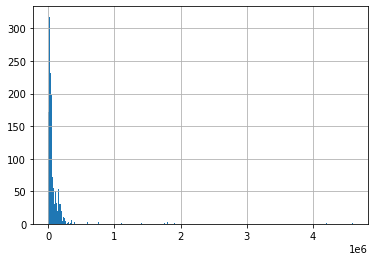

In [47]:
# 가격의 분포를 그래프로 탐색합니다.
df['price'].hist(bins="auto")

In [52]:
# 핸드폰 기종(phone_model)별 가격의 평균과 표준편차를 계산합니다.
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

ValueError: ignored

In [51]:
# 이를 바탕으로 모든 데이터의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종별 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

NameError: ignored

-----

##### 출고가 피처 탐색

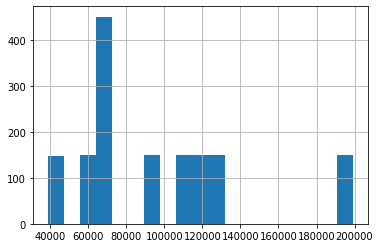

In [50]:
# factory_price 피처의 분포를 탐색합니다.
df['factory_price'].hist(bins="auto")

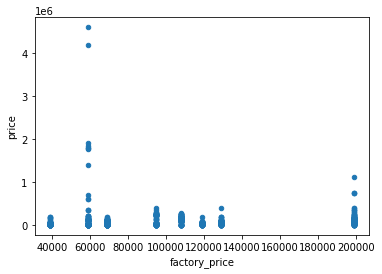

In [37]:
# factory_price와 price 피처를 scatter plot으로 출력하여, 상관관계를 살펴봅니다.
df.plot.scatter(x='factory_price', y='price')

-----

##### 핸드폰 모델 피처 탐색

count     10.000000
mean     149.800000
std        0.632456
min      148.000000
25%      150.000000
50%      150.000000
75%      150.000000
max      150.000000
Name: phone_model, dtype: float64


{'boxes': [<matplotlib.lines.Line2D at 0x7f00dcace1d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f00dca57250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f00dcac5710>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f00dca57d10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f00dcace790>,
  <matplotlib.lines.Line2D at 0x7f00dcacecd0>]}

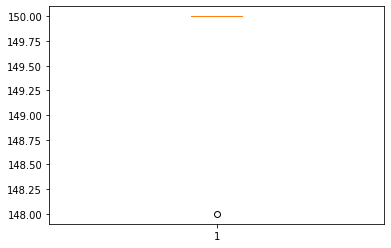

In [38]:
# 기종별 총 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴봅니다.
plt.boxplot(model_counts)

-----

##### 메이커 피처 탐색

ReeBok         150
Adidas         150
Puma           150
New_Balance    150
Nuovo          150
VANS           150
Converse       150
Nike           150
Birkenstock    150
hawkins        148
Name: maker, dtype: int64


{'boxes': [<matplotlib.lines.Line2D at 0x7f00d726d990>],
 'caps': [<matplotlib.lines.Line2D at 0x7f00d7270a10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f00d727aa50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f00d727a510>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f00d726df50>,
  <matplotlib.lines.Line2D at 0x7f00d72704d0>]}

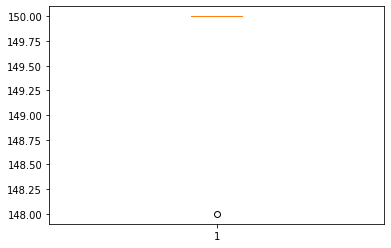

In [54]:
maker_counts = df['maker'].value_counts()
print(maker_counts)
plt.boxplot(maker_counts)

-----

### [Random forest regressor를 이용한 가격 예측]

In [43]:
df.head()

,price,factory_price,phone_model_나이키 에어맥스 97,phone_model_누오보 바베트,phone_model_뉴발란스 문빔,phone_model_리복 로얄 하이페리움 2,phone_model_반스 올드스쿨,phone_model_버켄스탁 아리조나,phone_model_아디다스 오즈위고,phone_model_컨버스 척테일러 올스타,phone_model_퓨마 스웨이드 빈티지,phone_model_호킨스 푸파,maker_Adidas,maker_Birkenstock,maker_Converse,maker_New_Balance,maker_Nike,maker_Nuovo,maker_Puma,maker_ReeBok,maker_VANS,maker_hawkins
0,350000.0,199000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,125000.0,199000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,130000.0,199000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2000.0,199000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,135000.0,199000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


-----

##### Random forest 모델 학습

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 데이터를 학습/테스트용 데이터로 분리합니다.
df = df[['price', 'phone_model', 'factory_price', 'maker']]
df = pd.get_dummies(df, columns=['phone_model', 'maker'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습합니다.
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델을 평가합니다.
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

KeyError: ignored

##### 피처 중요도 분석

In [ ]:
# 학습한 모델의 피처 중요도를 그래프로 살펴봅니다.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 학습한 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [ ]:
# month 피처 중, 영향력이 높은순으로 정렬하여 출력합니다.
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]: 
        print(sorted_feature)

-----

##### 예측 결과 scatter plot

In [ ]:
plt.scatter(y_test.values, y_test_pred)

-----

# <Step2. 피처 엔지니어링> : 예측 모델 개선

### [기존 feature의 가공]

In [ ]:
# 데이터를 다시 불러옵니다.
df = pd.read_csv("/content/gdrive/MyDrive/ML_team/used_mobile_phone.csv")

##### create_date로 시간점수 생성하기

In [ ]:
from datetime import datetime
import time

# create_date 피처를 수치적으로 계산하기 위해, unixtime으로 변환하는 함수를 정의합니다.
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

# create_date 피처를 ‘현재와 얼마나 가까운 데이터인 지’ 판단하기 위한 점수를 생성합니다. 먼저 unixtime으로 데이터를 변환합니다.
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))
print(df['create_unixtime'][:10])

0    1.489882e+09
1    1.477440e+09
2    1.477354e+09
3    1.490227e+09
4    1.460333e+09
5    1.490141e+09
6    1.490227e+09
7    1.475798e+09
8    1.490400e+09
9    1.458691e+09
Name: create_unixtime, dtype: float64


In [ ]:
# 변환된 unixtime에 min-max 스케일링을 적용합니다.
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
                          (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489882e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477440e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477354e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490227e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460333e+09,0.165468


-----

##### phone_model 피처 분리

In [ ]:
# phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출합니다.
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[[ 'phone_model_detail']].head()

,phone_model_detail
0,iphone 6
1,galaxy s6 edge
2,galaxy s6
3,lg g5
4,lg u


{'boxes': [<matplotlib.lines.Line2D at 0x7f9c30944650>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9c03b9b710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9c03b9f750>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9c03b9f210>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9c30944c50>,
  <matplotlib.lines.Line2D at 0x7f9c03bb2710>]}

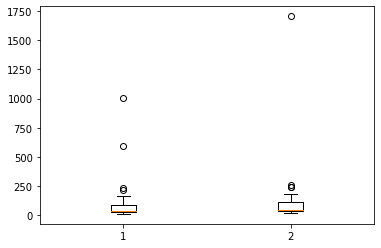

In [ ]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계합니다.
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처간의 기종별 거래 데이터 개수를 비교합니다.
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

-----

##### phone_model 관련 딕셔너리 생성

In [ ]:
# 기종명 으로 출고가를 찾기 위한 딕셔너리를 생성합니다.
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['phone_model_detail'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], "...")

{'iphone 6': 924000, 'galaxy s6 edge': 9 ...


-----

# <Step3. 예측> : 중고폰 거래가 예측

### [Random forest regressor 재학습]

MSE train: 7118634565.362, test: 14627138429.481
R^2 train: 0.853, test: 0.666


[('factory_price', 0.32521259761679844),
 ('maker_apple', 0.26792515913797477),
 ('create_time_score', 0.1727024382649339),
 ('phone_model_detail_galaxy s7 edge', 0.03149601897789514),
 ('phone_model_detail_galaxy note5', 0.029160058293200522),
 ('phone_model_detail_iphone 6', 0.027348652009935196),
 ('phone_model_detail_galaxy s7', 0.024158555316890082),
 ('phone_model_detail_iphone se', 0.01990496932241115),
 ('phone_model_detail_galaxy note7', 0.010674550251369435),
 ('phone_model_detail_iphone 5s', 0.009041154157716528)]

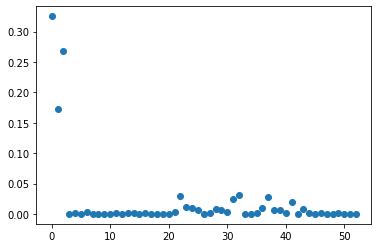

In [ ]:
# 랜덤 포레스트 모델 학습을 위한 데이터를 준비합니다.
df = df[['price', 'factory_price', 'maker', 'create_time_score', 'phone_model_detail']]
df = pd.get_dummies(df, columns=['maker', 'phone_model_detail',])

# 학습/테스트 데이터를 분리합니다.
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습하고 평가합니다.
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot을 출력합니다.
importances = forest.feature_importances_
plt.plot(importances, "o")

# 피처 중요도를 print로 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

------

##### feature-index 관련 딕셔너리 생성

In [ ]:
# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성합니다.
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'create_time_score' ...


-----

##### 예측 결과 scatter plot

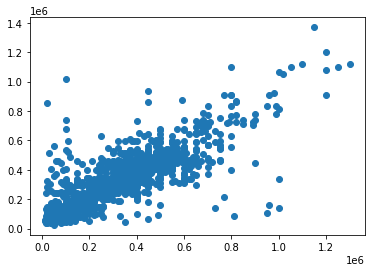

In [ ]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계를 살펴봅니다.
plt.scatter(y_test.values, y_test_pred)

-----

### [최적의 모델 파라미터 찾기]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정합니다.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의합니다.
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

# RandomizedSearchCV 모델을 학습합니다.
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

-----

##### 최적 파라미터 출력

In [ ]:
# 앞서 선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합을 출력합니다.
optimal_forest.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 400}

-----

##### 최적 모델 학습 결과

MSE train: 12515979471.581, test: 12321417236.796
R^2 train: 0.742, test: 0.718


[('factory_price', 0.22269324413523525),
 ('maker_apple', 0.14173929630137003),
 ('phone_model_detail_iphone 7', 0.12301975051466166),
 ('create_time_score', 0.10547261747075744),
 ('phone_model_detail_iphone 7 plus', 0.0631703891264856),
 ('maker_lg', 0.051445815278773184),
 ('phone_model_detail_iphone 6', 0.04694513827200203),
 ('phone_model_detail_galaxy s7 edge', 0.025977195729547122),
 ('phone_model_detail_iphone 5s', 0.024574379405911357),
 ('maker_samsung', 0.023552586002867314)]

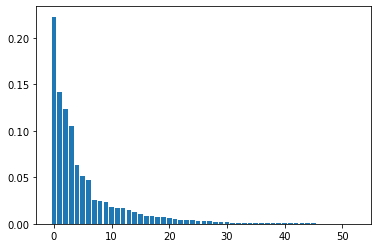

In [ ]:
# 최적의 파라미터를 적용한 모델로 중고폰의 가격을 예측하고 평가합니다.
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 가격 예측 모델의 피처 중요도 plot을 출력합니다.
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 가격 예측 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

-----

##### 예측 결과 scatter plot

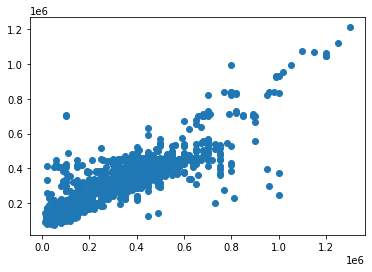

In [ ]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계를 살펴봅니다.
plt.scatter(y_test.values, y_test_pred)

-----

# <Step4. 프로토타입> : 얼마고(Almhago?)

### [재사용을 위한 파일 저장]

In [ ]:
import joblib

# 모델 예측을 위한 중간 오브젝트들을 각각 파일로 저장합니다.
with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'wb') as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, '../data/used_mobile_pickles/rf_regressor.pickle', compress = 1)

FileNotFoundError: ignored

-----

### [가격 예측 프로그램 만들기]

##### 예측에 필요한 파일 로드

In [ ]:
import pickle

with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'rb') as f:
    common_words = pickle.load(f)

with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
    svm_classifier = pickle.load(f)

rf_regressor = joblib.load('../data/used_mobile_pickles/rf_regressor.pickle')

-----

##### 프로그램(클래스) 만들기

In [ ]:
import numpy as np

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, 
                 common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                 prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()
        self._tfidf_vectorizer = tfidf_vectorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
        
    def _get_common_pos(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = ''.join(c for c in text if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
        
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_ftr_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
        X = self._tfidf_vectorizer.transform(X)
        return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ""
        if prd_status == "0":
            status = "불량한"
        elif prd_status == "1":
            status = "양호한"
        else:
            status = "좋은"
        print("선택하신", model, "모델은", status, "상태입니다. Almhago 예상 가격은", str(int(price[0])), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['phone_model_detail'],
                                                                                input_dict['phone_model_storage'])
        feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict['phone_model_detail']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict['text'])])]] = 1
        
        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['phone_model_detail'], 
                            predicted_price, 
                            self._get_prd_status(input_dict['text']))

-----

##### 프로그램 테스트

In [ ]:
# 데이터의 가장 최근 시점인 2017년 4월을 기준으로 하기 위한 두 개(price_index, create_time_score)의 피처를 정의합니다.
recent_price_index = 95.96
recent_create_time_score = 1.0

# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글을 입력합니다.
program_test_dict = {"maker": "apple",
                     "phone_model_detail": "iphone 6",
                     "phone_model_storage": "16gb",
                     "text": '아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요',
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트를 생성합니다.
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)

# 입력한 데이터로 판매 가격을 예측합니다.
almhago.predict(program_test_dict)

NameError: ignored